In [1]:
from edgeml import edgeml
import pandas as pd
import tsfresh as ts
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from datetime import timedelta

In [2]:
project = edgeml.getProject("https://app.edge-ml.org",
                            "dSCctVkGbmT/tMoPX4u6/2lzjQ82zWLweyUpBP7C/oYeXtNGi9iyiwMXr+JTbBzh+Yk1Oh/kJZiiGM/y6HLj2Q==")

fetching project...


In [3]:
data_list = []
for dataset in project["datasets"]:
    label = dataset['labels'][0][0]['name']
    data_obj = {}
    for sensor in dataset["sensors"]:
        sensor_name = sensor['name']
        for datapoint in sensor["data"]:
            if datapoint['timestamp'] not in data_obj:
                data_obj[datapoint['timestamp']] = {}
            if 'label' not in data_obj[datapoint['timestamp']]:
                data_obj[datapoint['timestamp']]['label'] = label
            data_obj[datapoint['timestamp']][sensor_name] = datapoint["datapoint"]
    df = pd.DataFrame.from_dict(data_obj, orient='index')
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'timestamp'}, inplace=True)
    df['timestamp'] = pd.to_datetime(df['timestamp'] / 1000, unit='s')
    #df.to_csv(f"../data/original/{label}.csv", index=False)
    data_list.append(df)

In [4]:
data_list[0].head()

,timestamp,label,x0,y0,z0,x,y,z,alpha,beta,gamma
0,2022-08-11 10:37:02.815000064,reading,0.00,0.01,-0.02,-0.23,-6.99,-6.89,-3.19,0.38,-1.16
1,2022-08-11 10:37:02.831000064,reading,0.00,0.07,0.01,-0.22,-6.92,-6.87,-4.89,-1.07,-0.50
2,2022-08-11 10:37:02.846999808,reading,0.00,0.05,-0.12,-0.23,-6.92,-7.01,-5.93,-1.34,-0.31
3,2022-08-11 10:37:02.864000000,reading,-0.01,0.01,-0.18,-0.24,-6.96,-7.08,-5.51,0.06,-0.37
4,2022-08-11 10:37:02.880999936,reading,-0.07,-0.02,-0.20,-0.30,-6.98,-7.11,-4.69,0.42,-0.97


In [5]:
for i, df in enumerate(data_list):
    start = df['timestamp'].to_list()[0].replace(microsecond=0) + timedelta(seconds=10)
    end = df['timestamp'].to_list()[-1].replace(microsecond=0) - timedelta(seconds=10)
    df = df[(df['timestamp'] > start) & (df['timestamp'] < end)]
    data_list[i] = df

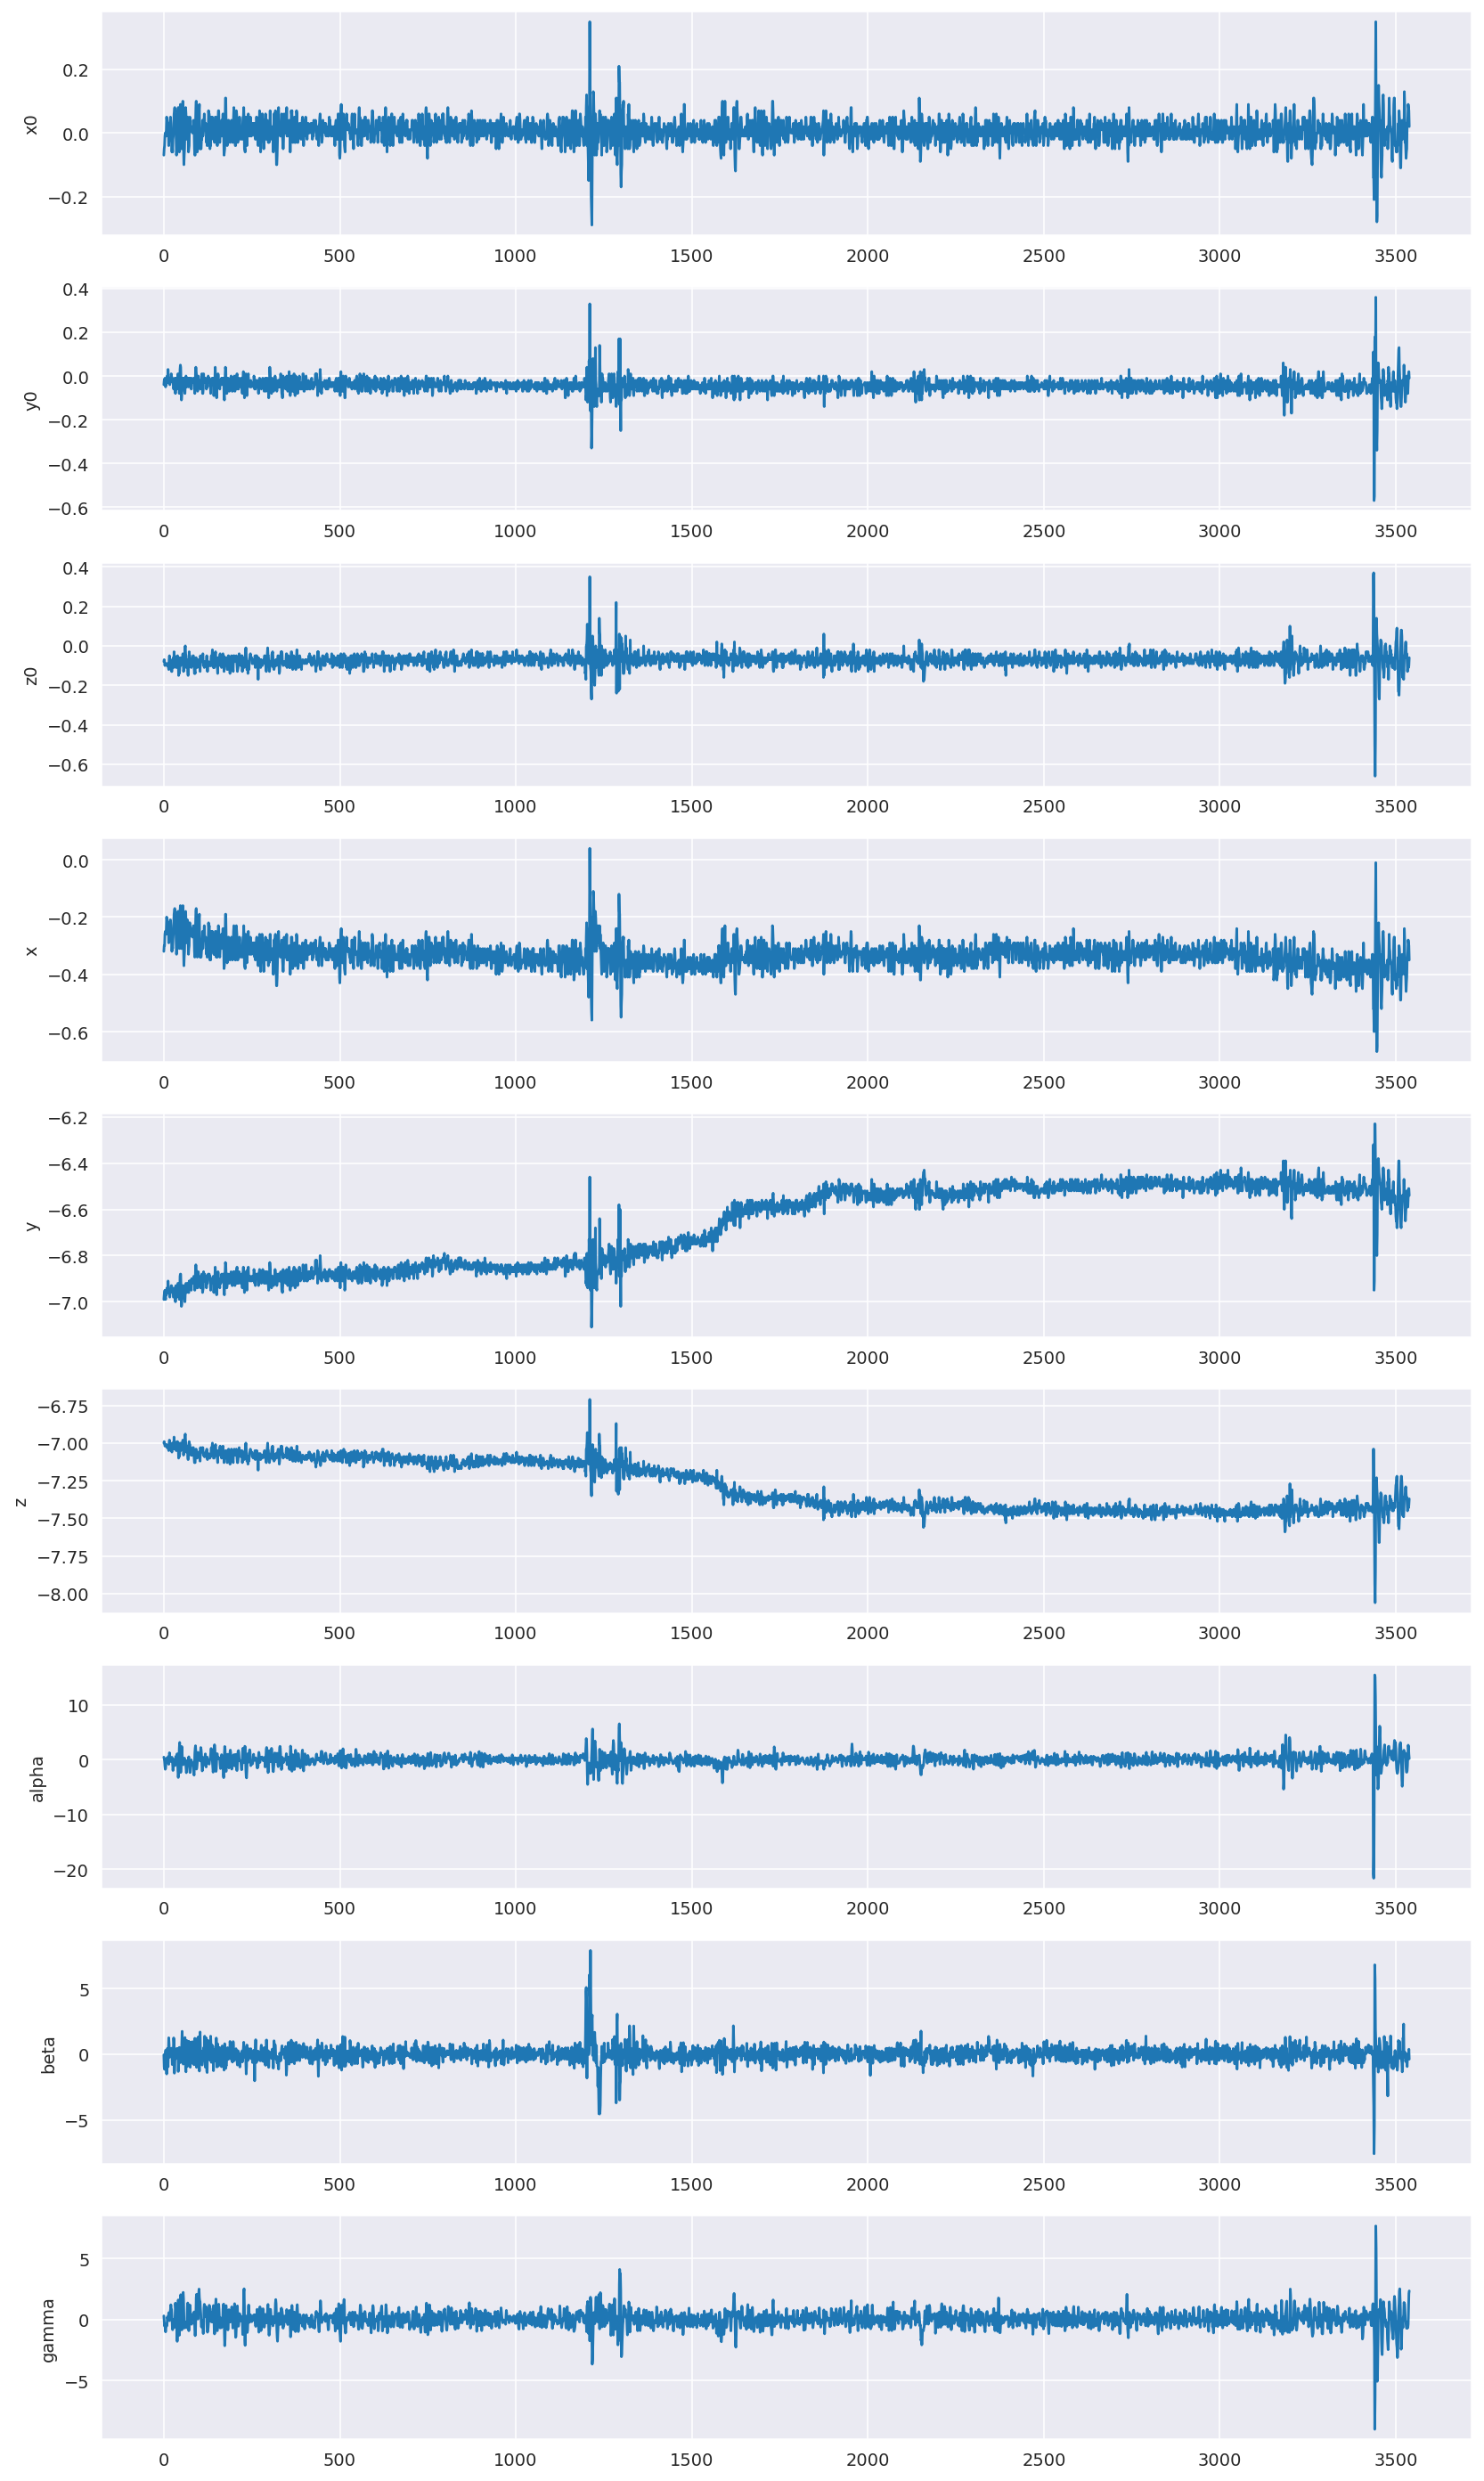

In [6]:
columns = data_list[0].columns.drop(['timestamp', 'label'])

fig, axes = plt.subplots(nrows=9, ncols=1, figsize=(12, 20), dpi=140)

for i, column in enumerate(columns):
    sns.lineplot(x=range(len(data_list[0])), y=column, data=data_list[0], ax=axes[i])

fig.tight_layout()
plt.show()

In [7]:
data_full = pd.DataFrame()
for data in data_list:
    data["window"] = data.apply(lambda x: x['timestamp'].round(freq="1s"), axis=1)
    label = data["label"].iloc[0]
    data.drop(columns=['timestamp', 'label'], inplace=True)
    data = ts.extract_features(data, column_id="window",
                               default_fc_parameters=ts.feature_extraction.MinimalFCParameters())
    data.reset_index(inplace=True)
    data.rename(columns={'index': 'timestamp'}, inplace=True)
    data['label'] = label
    data_full = pd.concat([data_full, data])
    #data.to_csv(f"../data/features/{label}.csv", index=False)

data_full.to_csv(f"../data/data.csv", index=False)

Feature Extraction: 100%|█████████████████████| 38/38 [00:00<00:00, 1486.77it/s]


In [8]:
data_full.head()

,timestamp,x0__sum_values,x0__median,x0__mean,x0__length,x0__standard_deviation,x0__variance,x0__root_mean_square,x0__maximum,x0__minimum,...,gamma__sum_values,gamma__median,gamma__mean,gamma__length,gamma__standard_deviation,gamma__variance,gamma__root_mean_square,gamma__maximum,gamma__minimum,label
0,2022-08-11 10:37:12,-0.03,0.000,-0.001000,30.0,0.035903,0.001289,0.035917,0.06,-0.07,...,-1.35,-0.040,-0.045000,30.0,0.556434,0.309618,0.558250,1.20,-1.02,reading
1,2022-08-11 10:37:13,0.39,0.010,0.006500,60.0,0.049994,0.002499,0.050415,0.10,-0.10,...,8.37,0.065,0.139500,60.0,0.937588,0.879071,0.947909,2.22,-1.80,reading
2,2022-08-11 10:37:14,0.77,0.010,0.012833,60.0,0.040665,0.001654,0.042642,0.10,-0.06,...,24.19,0.450,0.403167,60.0,0.921075,0.848378,1.005446,2.49,-1.19,reading
3,2022-08-11 10:37:15,0.63,0.015,0.010500,60.0,0.039683,0.001575,0.041049,0.11,-0.07,...,0.88,-0.020,0.014667,60.0,0.793319,0.629355,0.793454,1.29,-2.16,reading
4,2022-08-11 10:37:16,0.57,0.010,0.009500,60.0,0.030953,0.000958,0.032378,0.08,-0.06,...,0.39,0.035,0.006500,60.0,0.748418,0.560129,0.748446,2.51,-2.13,reading


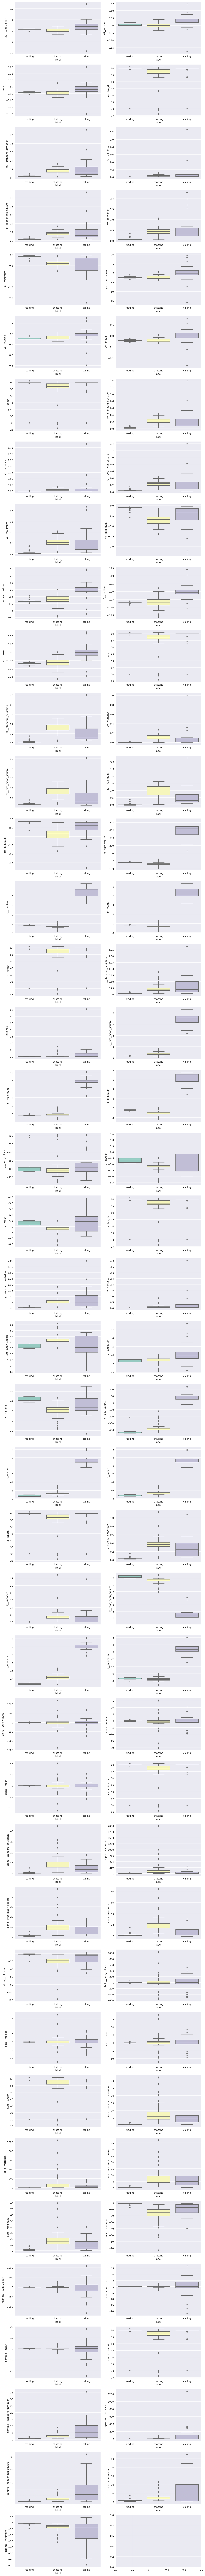

In [9]:
columns = data_full.columns.drop(['timestamp', 'label'])

fig, axes = plt.subplots(nrows=math.ceil(len(columns) / 2), ncols=2, figsize=(12, 150), dpi=140)

for i, column in enumerate(columns):
    sns.boxplot(x='label', y=column, data=data_full, ax=axes[i // 2, i % 2], palette="Set3")

fig.tight_layout()
plt.show()

In [10]:
X = data_full.drop(['timestamp', 'label'], axis=1)
y = data_full['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train.to_csv(f"../data/X_train.csv", index=False)
X_test.to_csv(f"../data/X_test.csv", index=False)
y_train.to_csv(f"../data/y_train.csv", index=False)
y_test.to_csv(f"../data/y_test.csv", index=False)